In [2]:
# 1. Importação das Bibliotecas Necessárias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# 2. Coleta de Dados Históricos dos Ativos
tickers = ['TAEE4.SA', 'VALE3.SA', 'VIVT3.SA', 'BBSE3.SA', 'BBAS3.SA']
start_date = '2010-01-01'
end_date = '2024-10-31'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Criar um DataFrame vazio para armazenar os dividendos
dividends = pd.DataFrame()

# Para cada ativo, baixar os dados de dividendos
for ticker in tickers:
    # Baixar dados de dividendos
    div = yf.Ticker(ticker).dividends
    # Filtrar pelo período desejado
    div = div.loc[start_date:end_date]
    # Atribuir ao DataFrame de dividendos
    dividends[ticker] = div

# Sincronizar as datas dos dividendos com os preços
dividends = dividends.reindex(data.index).fillna(0)

# Inicializar um DataFrame para os retornos totais
total_returns = pd.DataFrame(index=data.index, columns=tickers)

for ticker in tickers:
    # Preços ajustados e dividendos para o ativo
    prices = data[ticker]
    divs = dividends[ticker]
    
    # Calcular o retorno total diário
    # Retorno total = (Preço de hoje + Dividendo de hoje) / Preço de ontem - 1
    total_returns[ticker] = (prices + divs).pct_change()


total_returns.shape, total_returns.dropna().shape
total_returns.dropna()

[*********************100%***********************]  5 of 5 completed


,TAEE4.SA,VALE3.SA,VIVT3.SA,BBSE3.SA,BBAS3.SA
Date,,,,,
2017-05-11 00:00:00+00:00,0.000000,-0.009036,-0.003431,0.001646,0.031185
2017-05-12 00:00:00+00:00,0.000000,-0.015578,0.024894,0.023989,0.029078
2017-05-15 00:00:00+00:00,0.000000,0.028560,-0.006718,-0.005135,-0.018084
2017-05-16 00:00:00+00:00,0.000000,0.022889,-0.005463,0.020645,0.000000
2017-05-17 00:00:00+00:00,0.000000,-0.015407,-0.030866,-0.017067,-0.027050
...,...,...,...,...,...
2024-10-24 00:00:00+00:00,-0.001739,0.005897,0.001863,0.001166,0.001139
2024-10-25 00:00:00+00:00,0.000000,0.034003,-0.006323,-0.001746,0.000379
2024-10-28 00:00:00+00:00,0.001742,0.018630,0.008048,0.002332,-0.001896


In [ ]:
# 3. Cálculo dos Retornos Diários e Estatísticas
total_returns = total_returns.dropna()
mean_returns = total_returns.mean()
cov_matrix = total_returns.cov()

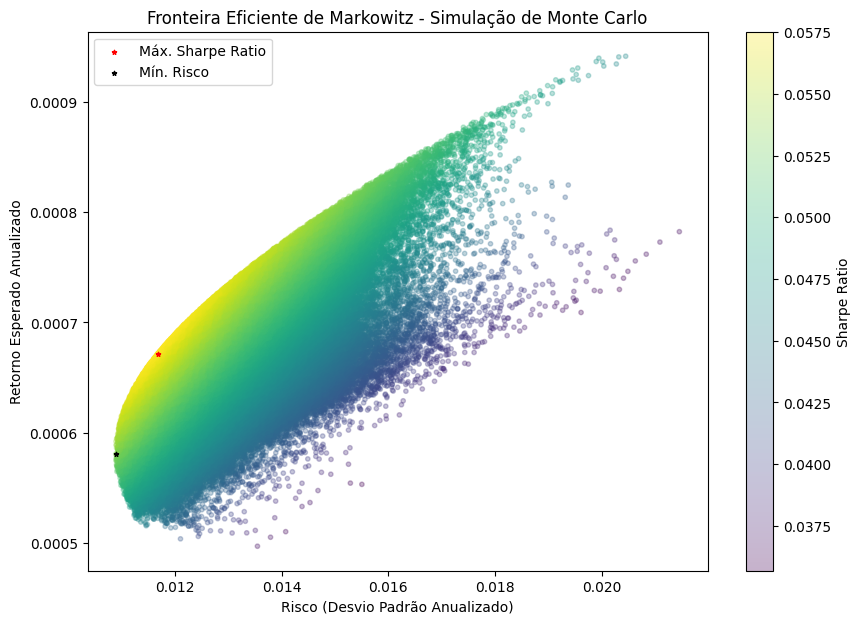

Pesos do Portfólio de Máximo Sharpe Ratio:
TAEE4.SA: 28.35%
VALE3.SA: 29.42%
VIVT3.SA: 24.57%
BBSE3.SA: 15.13%
BBAS3.SA: 2.53%

Pesos do Portfólio de Mínimo Risco:
TAEE4.SA: 34.42%
VALE3.SA: 11.84%
VIVT3.SA: 27.88%
BBSE3.SA: 25.77%
BBAS3.SA: 0.09%


In [13]:
# 4. Simulação de Portfólios Aleatórios
num_portfolios = 200000
results = np.zeros((3, num_portfolios))
all_weights = np.zeros((num_portfolios, len(tickers)))

for i in range(num_portfolios):
    # Gerar pesos aleatórios
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Calcula o retorno e risco do portfólio
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Armazena os resultados
    results[0,i] = portfolio_std_dev
    results[1,i] = portfolio_return
    results[2,i] = results[1,i] / results[0,i]

    # Armazena os pesos
    all_weights[i, :] = weights

# 5. Visualização da Fronteira Eficiente
results_frame = pd.DataFrame(results.T, columns=['Risco', 'Retorno', 'Sharpe'])
for i, ticker in enumerate(tickers):
    results_frame[ticker + '_weight'] = all_weights[:, i]

# Plotar os portfólios simulados
plt.figure(figsize=(10, 7))
plt.scatter(results_frame['Risco'], results_frame['Retorno'], c=results_frame['Sharpe'], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risco (Desvio Padrão Anualizado)')
plt.ylabel('Retorno Esperado Anualizado')
plt.title('Fronteira Eficiente de Markowitz - Simulação de Monte Carlo')

# 6. Encontrar os Portfólios Ótimos
max_sharpe_idx = results_frame['Sharpe'].idxmax()
max_sharpe_port = results_frame.loc[max_sharpe_idx]
min_risk_idx = results_frame['Risco'].idxmin()
min_risk_port = results_frame.loc[min_risk_idx]

# Plotar os portfólios ótimos
plt.scatter(max_sharpe_port['Risco'], max_sharpe_port['Retorno'], marker='*', color='r', s=10, label='Máx. Sharpe Ratio')
plt.scatter(min_risk_port['Risco'], min_risk_port['Retorno'], marker='*', color='black', s=10, label='Mín. Risco')
plt.legend()
plt.show()

# 7. Análise dos Pesos dos Portfólios Ótimos
print("Pesos do Portfólio de Máximo Sharpe Ratio:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {max_sharpe_port[ticker + '_weight']:.2%}")

print("\nPesos do Portfólio de Mínimo Risco:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {min_risk_port[ticker + '_weight']:.2%}")